<a href="https://colab.research.google.com/github/BobojonM/NeuralNetworks/blob/main/Seminar_4_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 76281649.68it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77254906.78it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20351092.45it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15576883.70it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

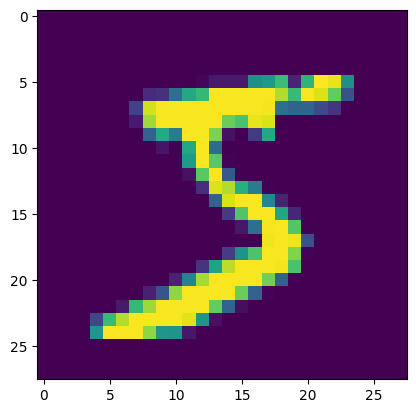

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()

        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm

        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError

        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer

        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer

        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function

        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)

        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

In [10]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)

    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    print('---------------')
    return test_accuracy_history, test_loss_history

accuracies = {}
losses = {}


accuracies['tanh'], losses['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu'], losses['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)

accuracies['relu_3'], losses['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool'], losses['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'),
          X_train, y_train, X_test, y_test)

accuracies['relu_3_max_pool_bn'], losses['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True),
          X_train, y_train, X_test, y_test)

tensor(0.9769)
tensor(0.9823)
tensor(0.9863)
tensor(0.9852)
tensor(0.9874)
tensor(0.9880)
tensor(0.9895)
tensor(0.9877)
tensor(0.9864)
tensor(0.9872)
tensor(0.9868)
tensor(0.9877)
tensor(0.9875)
tensor(0.9886)
tensor(0.9895)
tensor(0.9897)
tensor(0.9889)
tensor(0.9878)
tensor(0.9895)
tensor(0.9897)
tensor(0.9879)
tensor(0.9874)
tensor(0.9871)
tensor(0.9879)
tensor(0.9903)
tensor(0.9896)
tensor(0.9881)
tensor(0.9875)
tensor(0.9890)
tensor(0.9886)
---------------
tensor(0.9840)
tensor(0.9866)
tensor(0.9874)
tensor(0.9868)
tensor(0.9897)
tensor(0.9901)
tensor(0.9880)
tensor(0.9907)
tensor(0.9880)
tensor(0.9900)
tensor(0.9900)
tensor(0.9894)
tensor(0.9882)
tensor(0.9914)
tensor(0.9905)
tensor(0.9918)
tensor(0.9859)
tensor(0.9909)
tensor(0.9901)
tensor(0.9894)
tensor(0.9893)
tensor(0.9917)
tensor(0.9893)
tensor(0.9901)
tensor(0.9888)
tensor(0.9889)
tensor(0.9907)
tensor(0.9909)
tensor(0.9911)
tensor(0.9884)
---------------
tensor(0.9797)
tensor(0.9859)
tensor(0.9869)
tensor(0.9853)
tensor(0

In [ ]:
# выводы по графикам

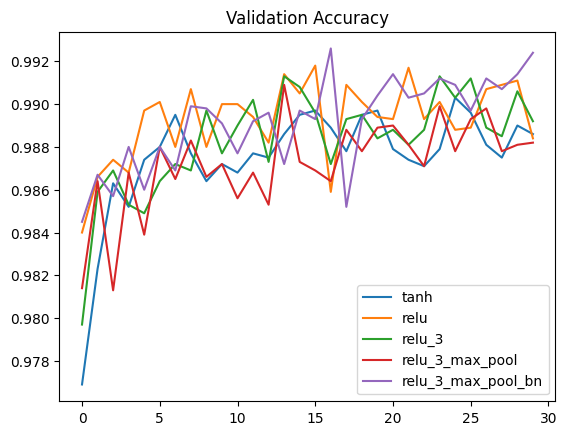

In [11]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

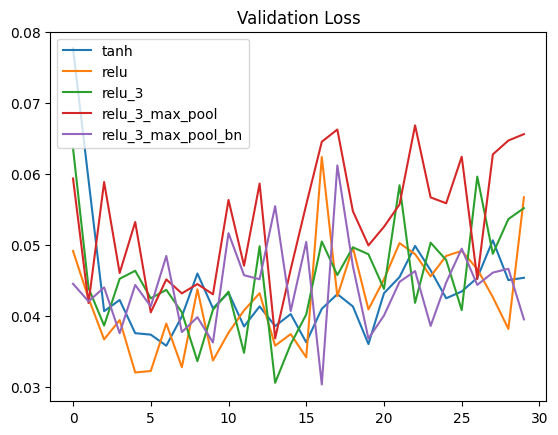

In [12]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

# Homework
# Problems 1 (20 Points)

Let's check the statement about gradient decay in practice. In the [pytorch documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) you can find the following activation functions (we have highlighted the most popular ones in bold):

**ELU**, Hardtanh, **LeakyReLU**, LogSigmoid, PReLU, **ReLU**, ReLU6, RReLU, SELU, CELU, **Sigmoid**, Softplus, Softshrink, Softsign, **Tanh**, Tanhshrink, Hardshrink.

You have to find the activation that causes the least amount of gradient decay.

To test, we will construct a SimpleNet, which will have 3 fc layers inside, 1 neuron in each without biases. We will initialize the weights of these neurons by units. We will input numbers from the normal distribution to this network. Let's make 200 runs (NUMBER_OF_EXPERIMENTS) for a fair comparison and calculate the average gradient value in the first layer. Find a function that will give the maximum gradient values in the first layer. All activation functions must be initialized with default arguments (empty parentheses).

In [14]:
import torch
import numpy as np

seed = int(input())
np.random.seed(seed)
torch.manual_seed(seed)

NUMBER_OF_EXPERIMENTS = 200

class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()

        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False)  # one neuron without bias
        self.fc1.weight.data.fill_(1.)  # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x

    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)

def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward()  # no loss function. Pretending that we want to minimize output
                       # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

activations = [
    torch.nn.ELU(), torch.nn.Hardtanh(), torch.nn.LeakyReLU(), torch.nn.LogSigmoid(),
    torch.nn.PReLU(), torch.nn.ReLU(), torch.nn.ReLU6(), torch.nn.RReLU(),
    torch.nn.SELU(), torch.nn.CELU(), torch.nn.Sigmoid(), torch.nn.Softplus(),
    torch.nn.Softshrink(), torch.nn.Softsign(), torch.nn.Tanh(), torch.nn.Tanhshrink(),
    torch.nn.Hardshrink()
]

avg_gradients = {}

for activation in activations:
  net = SimpleNet(activation=activation)

  fc1_grads = []
  for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
      fc1_grads.append(get_fc1_grad_abs_value(net, x))

  print(np.mean(fc1_grads))
  avg_gradients[type(activation).__name__] = np.mean(fc1_grads)

# Finding the activation function with the maximum average gradient
max_gradient = max(avg_gradients, key=avg_gradients.get)
max_gradient_value = avg_gradients[max_gradient]

max_gradient, max_gradient_value

200
0.5053369248117088
0.2939148208172992
0.41275287397268273
0.24068364434409886
0.4151925321175804
0.43214249089360235
0.4327809628099203
0.4216583448013989
0.5881407115492039
0.43362648397684095
0.00724388888170779
0.2780644632561598
0.22426412045955657
0.0642455176427029
0.17419027406023815
0.02563060316973112
0.6100528940558434


('Hardshrink', 0.6100528940558434)